In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/HistoricalData_1717138717541.csv')

data.head()

,Date,Close/Last,Open,High,Low
0,05/30/2024,10205.24,10332.57,10348.39,10174.34
1,05/29/2024,10396.40,10386.55,10451.02,10386.55
2,05/28/2024,10526.85,10592.65,10594.29,10462.57
3,05/24/2024,10549.22,10494.50,10616.85,10480.60
4,05/23/2024,10495.82,10698.18,10704.39,10444.49


In [5]:
data.drop(columns=['Open', 'High', 'Low'], inplace=True)

In [6]:
data = data.set_index('Date')
data = data.iloc[::-1]
# data = data.loc['10/30/2023':'5/29/2024']

data

,Close/Last
Date,
05/31/2019,4237.28
06/03/2019,4170.02
06/04/2019,4320.98
06/05/2019,4329.21
06/06/2019,4375.45
...,...
05/23/2024,10495.82
05/24/2024,10549.22
05/28/2024,10526.85


In [7]:
data.reset_index(inplace = False)
data

,Close/Last
Date,
05/31/2019,4237.28
06/03/2019,4170.02
06/04/2019,4320.98
06/05/2019,4329.21
06/06/2019,4375.45
...,...
05/23/2024,10495.82
05/24/2024,10549.22
05/28/2024,10526.85


In [8]:
# Kiểm tra giá trị thiếu
data.isnull().sum()


Close/Last    0
dtype: int64

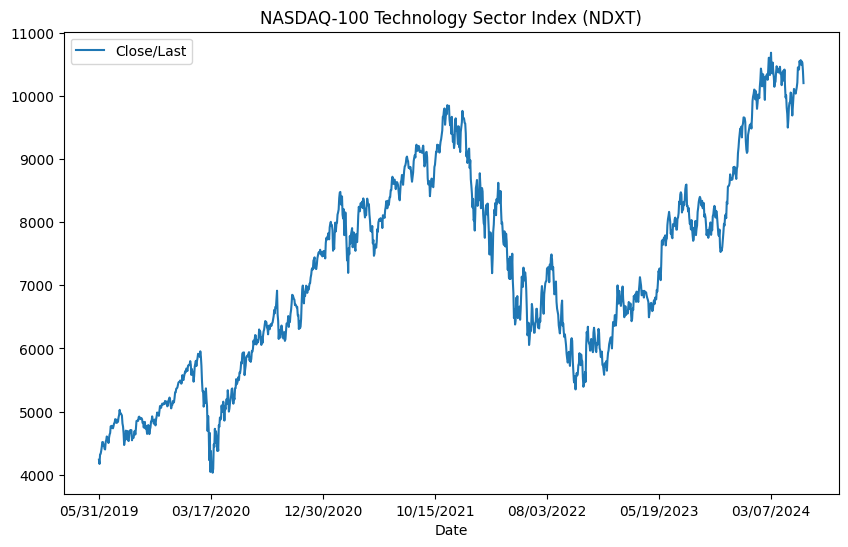

In [9]:
# Vẽ biểu đồ dữ liệu thời gian
data.plot(figsize=(10, 6))
plt.title('NASDAQ-100 Technology Sector Index (NDXT)')
plt.show()

Tiền xử lý dữ liệu

In [10]:
import torch
from sklearn.preprocessing import MinMaxScaler

In [11]:
seq_length = 30
num_predict = 1

In [12]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = int(len(data) * 0.1)
data_test_pre = data.iloc[train_size + val_size:]

In [13]:
def sliding_windows(data, seq_length, num_predict=1):
    x = []
    y = []

    for i in range(data.shape[0]-seq_length-num_predict):
        _x = data[i:(i+seq_length), :] # shape (seq_length, num_symbols)
        _y = data[(i+seq_length):(i+seq_length+num_predict), :][0] # shape (num_symbols,)
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# X_pre, y_pre = sliding_windows(data, seq_length=seq_length, num_predict=num_predict)
# train_size = int(len(y_pre) * 0.8)
# val_size = int(len(y_pre) * 0.1)
# test_size = int(len(y_pre) * 0.1)
# data_test = data.iloc[train_size + val_size:]

# Scaling dataset
sc = MinMaxScaler(feature_range=(-1, 1))
training_data = sc.fit_transform(data)
X, y = sliding_windows(training_data, seq_length=seq_length, num_predict=num_predict)

print(X.shape, y.shape)

(1228, 30, 1) (1228, 1)


In [14]:
# Train/test split
train_size = int(len(y) * 0.8)
val_size = int(len(y) * 0.1)
test_size = int(len(y) * 0.1)

data_test = data.iloc[train_size + val_size:]


trainX = np.array(X[:train_size])
trainY = np.array(y[:train_size])

valX = np.array(X[train_size:train_size + val_size])
valY = np.array(y[train_size:train_size + val_size])

testX = np.array(X[train_size + val_size:])
testY = np.array(y[train_size + val_size:])

print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(982, 30, 1) (122, 30, 1) (124, 30, 1)
(982, 1) (122, 1) (124, 1)


In [15]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(60),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(valX, valY), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 1))), axis=1))[:,0]

Epoch 1/20
31/31 [==============================] - 10s 70ms/step - loss: 0.0644 - val_loss: 0.0070
Epoch 2/20
31/31 [==============================] - 1s 33ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 3/20
31/31 [==============================] - 1s 32ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 4/20
31/31 [==============================] - 1s 41ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 5/20
31/31 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 6/20
31/31 [==============================] - 1s 21ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 7/20
31/31 [==============================] - 1s 24ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 8/20
31/31 [==============================] - 1s 26ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/20
31/31 [==============================] - 1s 26ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/20
31/31 [==============================] - 1s 26ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 11

In [16]:
data_test['Close/Last'].values[seq_length+1:]

array([ 8878.94,  8767.82,  8749.09,  8686.94,  8847.  ,  8887.07,
        9095.48,  9184.73,  9311.25,  9404.68,  9483.86,  9475.25,
        9514.86,  9344.42,  9523.19,  9566.56,  9661.82,  9660.16,
        9650.4 ,  9587.92,  9286.98,  9152.49,  9098.91,  9122.27,
        9382.04,  9431.27,  9488.72,  9539.06,  9534.17,  9562.14,
        9485.01,  9658.97,  9921.77,  9994.6 , 10035.03, 10103.12,
       10092.35,  9947.71, 10077.29,  9974.82,  9797.68,  9888.86,
       10021.72, 10017.66,  9966.25, 10145.02, 10256.3 , 10435.12,
       10371.7 , 10154.5 , 10347.87, 10342.72, 10225.03, 10122.3 ,
        9939.39, 10306.18, 10265.71, 10329.92, 10347.51, 10257.58,
       10411.78, 10606.23, 10606.42, 10332.76, 10475.54, 10686.65,
       10415.33, 10359.64, 10530.35, 10391.86, 10298.42, 10146.99,
       10221.21, 10224.57, 10372.62, 10472.44, 10444.17, 10388.22,
       10373.65, 10427.4 , 10420.33, 10463.7 , 10348.49, 10372.26,
       10172.51, 10306.57, 10309.02, 10400.32, 10243.23, 10419

In [17]:
predicted_stock_price

array([ 8782.35710809,  8813.01246208,  8847.10788618,  8854.96495278,
        8848.77847984,  8823.67315855,  8826.32405069,  8844.24593827,
        8908.30542939,  8997.09831553,  9108.308339  ,  9228.31714641,
        9346.38102734,  9439.83052966,  9512.26649482,  9525.67409   ,
        9544.29262029,  9561.4379258 ,  9591.23150181,  9619.21444151,
        9640.70602791,  9643.98056604,  9581.36702511,  9477.82810509,
        9361.33464568,  9261.75996388,  9236.81967867,  9257.04572392,
        9311.59987036,  9386.66371783,  9460.19899788,  9527.69974928,
        9565.15421317,  9615.45213446,  9706.11645445,  9807.84215948,
        9905.37412299,  9996.56052829, 10064.82437323, 10082.31542141,
       10097.00740201, 10081.73422461, 10022.13378243,  9970.22517241,
        9950.87746825,  9947.16812351,  9945.06649208,  9980.73174262,
       10046.2413495 , 10148.02259553, 10237.39261207, 10269.95331958,
       10308.43985409, 10334.20968367, 10326.91973027, 10287.14821526,
      

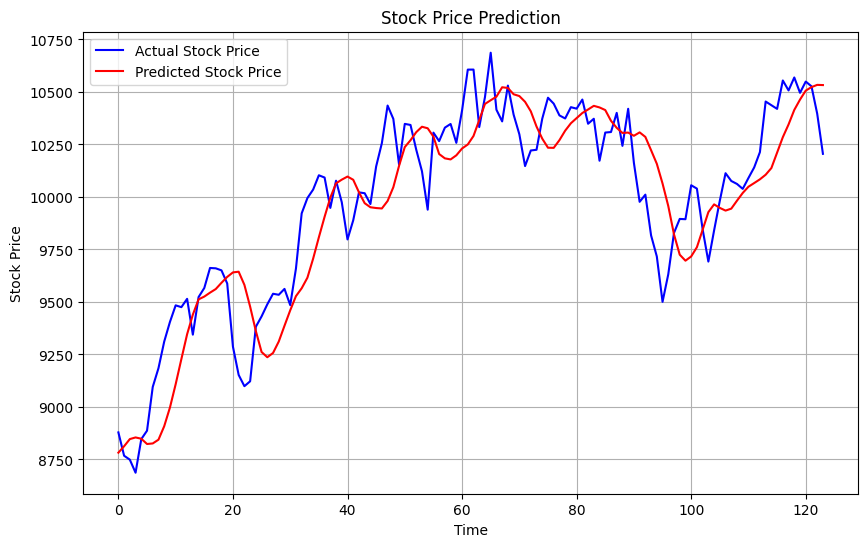

Root Mean Squared Error: 217.82121451625002
Mean Absolute Percentage Error: 0.017482885355135806


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test['Close/Last'].values[seq_length+1:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")
